In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import optimize
import random
from tabulate import tabulate

In [3]:
T = pd.read_csv('/Users/siyangwei/Documents/ANES_datasets/anes_timeseries_cdf_csv_20220916/anes_timeseries_cdf_csv_20220916.csv', low_memory=False)

In [4]:
T['VCF0101'] = pd.to_numeric(T['VCF0101'],errors='coerce',downcast='integer')
T = T[T['VCF0101']<=80]   # restrict age <= 80
T['VCF0004'] = pd.to_numeric(T['VCF0004'],errors='coerce',downcast='integer')
year = T['VCF0004']       
yr = set(year)      # extract survey years
age = T['VCF0101']       # extract respondent age
M = pd.concat([year,age],axis=1,join='inner')

In [5]:
# Filter binary questions
coln = len(T.columns)  # number of columns(variables)
questions = {}
for i in range(153,coln):
    values = set(T.iloc[:,i])
    values = [str(x) for x in values]
    avalues = [x for x in values if x.strip()]
    if len(avalues) <= 4 and '1' in avalues and '2' in avalues and '3' not in avalues:
        questions[T.columns[i]] = avalues

In [6]:
removekeys = ['VCF0358','VCF0359','VCF0360','VCF0361','VCF0370','VCF0371','VCF0372','VCF0373',
              'VCF0701','VCF0702','VCF0714','VCF0716','VCF0717','VCF0718','VCF0719','VCF0720',
             'VCF0721','VCF0722','VCF0724','VCF0725','VCF0726','VCF0727','VCF0729','VCF0730',
             'VCF0737','VCF0739','VCF0740','VCF0741','VCF0742',
              'VCF0903','VCF0904','VCF0905','VCF0978',
              'VCF1011','VCF1012','VCF1013',
             'VCF9030a','VCF9030b','VCF9030c','VCF9054','VCF9217','VCF9218','VCF9224','VCF9256',
             'VCF9257','VCF9258','VCF9260','VCF9261','VCF9262','VCF9265','VCF9278','VCF9280',
             'VCF9281','VCF9282']
for key in removekeys:
    del questions[key]

In [7]:
keylist = list(questions)
keylistlong = []
for k in keylist:
    col = T[k].astype('category')
    yearsur = year[(col == '1') | (col == '2')] # survey years
    yrsur = set(yearsur)
    if len(yrsur) >= 10:
        keylistlong.append(k)

In [8]:
keylistlong

['VCF0311',
 'VCF0312',
 'VCF0450',
 'VCF0501',
 'VCF0502',
 'VCF0605',
 'VCF0612',
 'VCF0619',
 'VCF0620',
 'VCF0621',
 'VCF0704a',
 'VCF0707',
 'VCF0708',
 'VCF0711',
 'VCF0816',
 'VCF0823',
 'VCF0829',
 'VCF0846',
 'VCF9236',
 'VCF9243']

In [9]:
# import real US matrix
Wim = pd.read_excel('/Users/siyangwei/Documents/contact_matrices_152_countries/MUestimates_all_locations_2.xlsx', sheet_name = 53, header = None)
Wim = Wim.to_numpy()

/Users/siyangwei/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [10]:
# preprocess interaction matrix
N = 16
WUS = np.copy(Wim)
# the real US matrix (scale entries by maximum row sum)
#rowsumax = max(np.sum(Wim, axis=1))
#WUS = WUS/rowsumax
#WUS = np.zeros([N,N])
# the real US matrix
#WUS[0,:] = Wim[0,:]/sum(Wim[0,:])
#WUS[1:N,:] = Wim[1:N,:]/2; # scale entries of W to speed up convergence

# constant matrix W
Wc = np.ones([N,N])
#Wc[1:N,:] = Wc[1:N,:]*5

# symmetrized US matrix
# scale WUS such that the first row and col both sums to 1
Wnml = np.copy(WUS)
# sc = sum(WUS[1:N,0])/(1-Wnml[0,0])
# Wnml[1:N,0] = WUS[1:N,0]/sc
Wsym = (Wnml + np.transpose(Wnml))/2

In [11]:
# matrix used for fit
W = np.copy(Wsym)

In [12]:
# Analyze a question
varname = 'VCF0501'   
# 1970 type of this question, 0009: 0, 0010: 1, 0011: 2
weightvar = 'VCF0009z'
if varname == 'VCF0816':
    weightvar = 'VCF0011z'
weight = T[weightvar]  
var = T[varname]
var = T[varname].astype('category')
D = M.join(var,how='inner')
Dw = D.join(weight, how = 'inner')

In [13]:
I = np.zeros([len(yr),5,13])  # 3d array, year, type and type percentage, 13 age groups
J = np.zeros([len(yr),5])  # 2d array, year, type and type percentage
yr = list(yr)
J[:,0] = yr;

for j in range(13): # 13 age groups
    
    # extract data for age group j
    maskj = (age > 5*(j+3)) & (age <= 5*(j+4))
    Mag = Dw[maskj == True]
    
    # count for each year
    I[:,0,j] = yr
    for i in range(len(yr)):
        maskyr = (Mag['VCF0004'] == yr[i])
        Magyr = Mag[maskyr == True]
        # number of opinion 1 in year i, age group j
        I[i,1,j] = Magyr.loc[Magyr[varname] == '1', weightvar].sum()
        I[i,2,j] = Magyr.loc[Magyr[varname] == '2', weightvar].sum()
        #I[i,1,j] = sum(Magyr[varname] == '1')
        #I[i,2,j] = sum(Magyr[varname] == '2')
        # number of opinion 1 in year i, all age groups
        J[i,1] += I[i,1,j]
        J[i,2] += I[i,2,j]

# delete the year without data for I and J
J2 = J[:,[1,2]]
J = J[~np.all(J2 == 0, axis = 1)]
t = J[:,0]
In = np.zeros([len(t),5,13])
for k in range(13):
    ind = np.isin(I[:,0,k],t)
    In[:,:,k] = I[ind,:,k]

np.seterr(invalid='ignore') # ignore 0/0 error, will return NaN
# compute opinion 1/ population of each year
In[:,3,:] = In[:,1,:]/np.sum(In[:,[1,2],:],1)
In[:,4,:] = In[:,2,:]/np.sum(In[:,[1,2],:],1)

J[:,3] = J[:,1]/np.sum(J[:,[1,2]],1)
J[:,4] = J[:,2]/np.sum(J[:,[1,2]],1)

In [14]:
# Initial Conditions
tmax = int((t[-1]-t[0]+5)//5 + 1) # ceil division, time gap = age group diff = 5 years
taxis = np.arange(0,tmax)*5 + t[0]
# use the same initial condition as in dataset
p = np.zeros([N,tmax])

# deal with NaN values: replace NaN with average
# p0[np.isnan(p0)] = np.mean(p0[~np.isnan(p0)])
# intead of replacing with average, replace NaN with the next available value in this age group
for i in range(3,N):
    if In[0,3,i-3] != In[0,3,i-3]:
        p[i,0] = next((x for x in In[:,3,i-3] if x == x))
    else:
        p[i,0] = In[0,3,i-3]
        
p[0:3,0] = In[0,3,2:5] # IC for age 0-15: assume the same as IC for age 25-40
p0 = p[:,0]

In [15]:
# simulation given be and ga
# be and ga are vectors of length tmax-1
def sim(be,ga):
    p = np.zeros([N, tmax])
    p[:, 0] = p0
    for i in range(tmax-1):
        p[0,i+1] = np.dot(W[0,:],p[:,i])/sum(W[0,:])
        for gp in range(1,N):
            p[gp,i+1] = np.dot(p[gp-1,i],(1-be[i]*np.dot(W[gp,:],(1-p[:,i])))) \
            + np.dot((1-p[gp-1,i]),ga[i]*np.dot(W[gp,:],p[:,i]))
    return p

In [16]:
# sse for linear, coordinated time-dependent model
# beta_t = c+a+gt, gamma_t = c-a-gt
def Jlct(param):
    c = param[0]
    a = param[1]
    gg = param[2]
    sse = 0
    be = (c+a)*np.ones(tmax-1) + gg*np.arange(0,tmax-1)
    ga = (c-a)*np.ones(tmax-1) - gg*np.arange(0,tmax-1)
    p = sim(be, ga)
    for k in range(13):
        kindex = ~np.isnan(In[:,3,k])
        pinterp = np.interp(t[kindex], taxis, p[k+3,:])
        sse += np.sum(np.square(pinterp - In[kindex,3,k]))
    return sse

In [17]:
# sse for linear, uncoordinated time-dependent model
# beta_t = c1+a1*t, gamma_t = c2+a2*t
def Jlut(param):
    c1 = param[0]
    a1 = param[1]
    c2 = param[2]
    a2 = param[3]
    sse = 0
    be = c1*np.ones(tmax-1) + a1*np.arange(0,tmax-1)
    ga = c2*np.ones(tmax-1) + a2*np.arange(0,tmax-1)
    p = sim(be, ga)
    for k in range(13):
        kindex = ~np.isnan(In[:,3,k])
        pinterp = np.interp(t[kindex], taxis, p[k+3,:])
        sse += np.sum(np.square(pinterp - In[kindex,3,k]))
    return sse

In [18]:
# sse for square model
# be = c + a + i * g + i^2 * f
# ga = c - a - i * g - i^2 * f
def Jsquare(param):
    c = param[0]
    a = param[1]
    g = param[2]
    f = param[3]
    sse = 0
    be = (c+a)*np.ones(tmax-1) + g*np.arange(0,tmax-1) + f*(np.arange(0,tmax-1)**2)
    ga = (c-a)*np.ones(tmax-1) - g*np.arange(0,tmax-1) - f*(np.arange(0,tmax-1)**2)
    p = sim(be, ga)
    for k in range(13):
        kindex = ~np.isnan(In[:,3,k])
        pinterp = np.interp(t[kindex], taxis, p[k+3,:])
        sse += np.sum(np.square(pinterp - In[kindex,3,k]))
    return sse

In [19]:
# backtracking line search
def BTLS(fun, w, dw, c = 0.01, gam = 0.5):
    fw = fun(w)
    dwnorm = np.linalg.norm(dw)
    d = -dw * 1e-5 / dwnorm     # descent direction
    deltaf = -c * 1e-5 * dwnorm
    newf = fun(w + d)
    t = 1
    while newf > fw + t * deltaf:
        t = gam * t
        newf = fun(w + t * d)
    return t, d

In [20]:
def grad_descent(fun,w_init,model,eps=1e-6, maxIter=500):
    w = w_init
    dw = np.ones(w_init.shape)
    W = []
    costs = []
    n_iter = 0
    
    W.append(w.copy())
    costs.append(fun(w))
    
    while n_iter < maxIter:
        # gradient of fun w.r.t. w
        dw = optimize.approx_fprime(w,fun,epsilon=1.4901161193847656e-08)
        if np.linalg.norm(dw) < 1e-8:
            break
            
        # adaptively choose step size
        lr, d = BTLS(fun, w, dw)
        w = w + lr * d
        
        cost = fun(w)
        
        # sanity check
        if model == 'lct':
            be = (w[0]+w[1])*np.ones(tmax-1) + w[2]*np.arange(0,tmax-1)
            ga = (w[0]-w[1])*np.ones(tmax-1) - w[2]*np.arange(0,tmax-1)
            
        if model == 'lut':
            be = w[0]*np.ones(tmax-1) + w[1]*np.arange(0,tmax-1)
            ga = w[2]*np.ones(tmax-1) + w[3]*np.arange(0,tmax-1)

        if model == 'square':
            be = (w[0]+w[1])*np.ones(tmax-1) + w[2]*np.arange(0,tmax-1) + w[3]*(np.arange(0,tmax-1)**2)
            ga = (w[0]-w[1])*np.ones(tmax-1) - w[2]*np.arange(0,tmax-1) - w[3]*(np.arange(0,tmax-1)**2)
                
        if max(be)>1 or min(be)<0 or max(ga)>1 or min(ga)<0:
            break
        else:
            W.append(w.copy())
            costs.append(cost)
            n_iter += 1    
    
    return W, costs

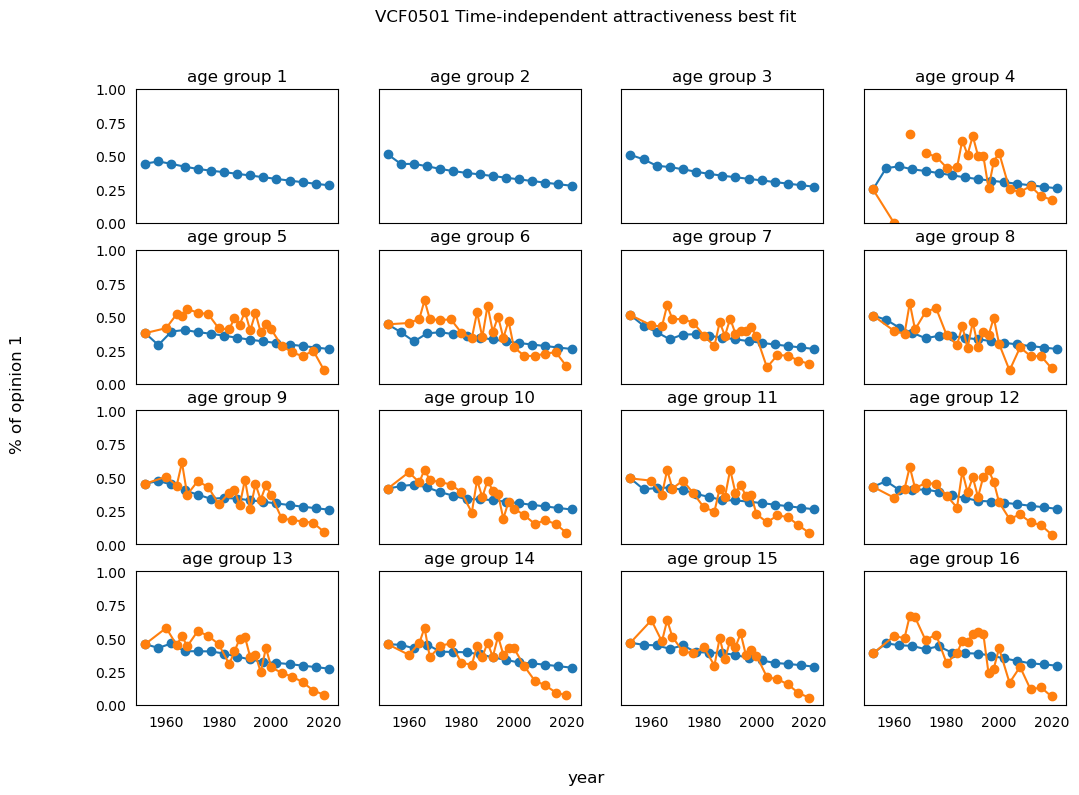

In [21]:
# import best parameters for constant model
# Read the CSV file into a DataFrame object
df = pd.read_csv('/Users/siyangwei/Documents/Python/OpinionDynamics/2opinioncoeffnew.csv')
df1 = df['Model 1']
ind = df.index[df['Question'] == varname].tolist()[0]
coeff1 = df1[df1.index % 3 == 2]
costr1 = coeff1[ind + 2].split(']')[0].split('[')[1:][0].split()
csopt = [0, 0]
csopt[0], csopt[1] = float(costr1[0]), float(costr1[1])
csopt = [0.02148, 0.002  ]
be = (csopt[0] + csopt[1]) * np.ones(tmax-1)
ga = (csopt[0] - csopt[1]) * np.ones(tmax-1)

# sanity check
for i in range(tmax-1):
    for j in range(1,N):
        if be[i]*sum(W[j,:])>1 or ga[i]*sum(W[j,:])>1:
            print('Warning')
p = sim(be, ga)
# sse for constant model
ssecs = 0
for k in range(13):
    kindex = ~np.isnan(In[:,3,k])
    pinterp = np.interp(t[kindex], taxis, p[k+3,:])
    ssecs += np.sum(np.square(pinterp - In[kindex,3,k]))
# time series graph for every age group
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    axs[i,j].plot(taxis,p[k,:],'-o')
    if k in range(3,16):
        axs[i,j].plot(t,In[:,3,k-3],'-o')
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(varname + ' Time-independent attractiveness best fit')
fig.supxlabel('year')
fig.supylabel('% of opinion 1')
plt.show()

In [22]:
#linear coordinated time-dependent model
i = 0
nt = 500
paramrec = np.zeros((3,nt))
costrec = np.zeros(nt)
while i < nt:
    init = np.zeros(3)
    if i == 0:
        init[0] = csopt[0]
        init[1] = csopt[1]
        init[2] = 0
    else:
        init[0] = random.uniform(0,0.1)
        init[1] = random.uniform(-0.1,0.1)
        init[2] = random.uniform(-0.001, 0.001)
    beinit = (init[0]+init[1])*np.ones(tmax-1) + init[2] * np.arange(0,tmax-1)
    gainit = (init[0]-init[1])*np.ones(tmax-1) - init[2] * np.arange(0,tmax-1)
    safe = True
    for k in range(tmax-1):
        for j in range(1, N):
            if beinit[k]*sum(W[j,:])>1 or gainit[k]*sum(W[j,:])>1:
                safe = False
                break
    if safe and min(beinit) > 0 and max(beinit) < 1 and min(gainit) > 0 and max(gainit) < 1:
        paramrec[:, i] = init
        costrec[i] = Jlct(init)
        params, costs = grad_descent(Jlct,init,'lct')
        lcopt = params[-1]
        be = (lcopt[0] + lcopt[1]) * np.ones(tmax-1) + lcopt[2] * np.arange(0, tmax-1)
        ga = (lcopt[0] - lcopt[1]) * np.ones(tmax-1) - lcopt[2] * np.arange(0, tmax-1)
        safe = True
        for k in range(tmax-1):
            for j in range(1, N):
                if be[k]*sum(W[j,:]) > 1 or ga[k]*sum(W[j, :])>1:
                    safe = False
        if np.isnan(params[-1]).any():
            continue
        if len(costs) >= 1 and min(costs) > 0 and safe:
            paramrec[:,i] = params[-1]
            costrec[i] = costs[-1]
            if i % 100 == 0:
                print(i, min(costrec[:i+1]))
            i += 1
        elif i == 0:
            i += 1

sselc = min(costrec)
besti = np.argmin(costrec)
lcopt = paramrec[:,besti]
print('minimum SSE for linear, coordinated model:',round(sselc,4))
print('parameters:',np.around(lcopt,decimals = 5))

0 2.653206919676747
100 2.599814698905562
200 2.5987184614769454
300 2.5987184614769454
400 2.5987184614769454
minimum SSE for linear, coordinated model: 2.5987
parameters: [ 0.03188 -0.00267  0.00108]


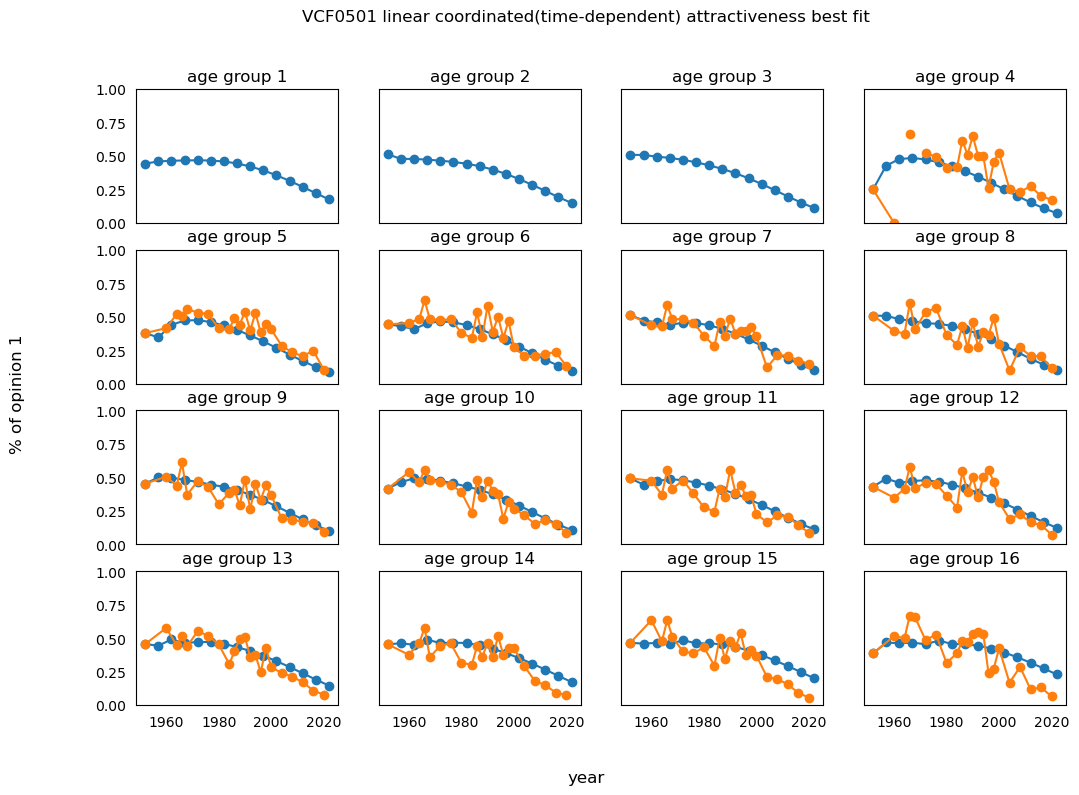

In [23]:
be = (lcopt[0] + lcopt[1]) * np.ones(tmax-1) + lcopt[2] * np.arange(0, tmax-1)
ga = (lcopt[0] - lcopt[1]) * np.ones(tmax-1) - lcopt[2] * np.arange(0, tmax-1)
# sanity check
for k in range(tmax-1):
    for i in range(1, N):
        if be[k]*sum(W[i,:]) > 1 or ga[k]*sum(W[i, :])>1:
            print('Warning')
p = sim(be, ga)
# time series graph for every age group
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    axs[i,j].plot(taxis,p[k,:],'-o')
    if k in range(3,16):
        axs[i,j].plot(t,In[:,3,k-3],'-o')
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(varname + ' linear coordinated(time-dependent) attractiveness best fit')
fig.supxlabel('year')
fig.supylabel('% of opinion 1')
plt.savefig('2opinionweightedtimefits/lct'+varname+'.jpg')
plt.show()

In [24]:
# linear, uncoordinated model
# be = a1 + i*g1, ga = a2 + i*g2
i = 0
nt = 1000
paramrec = np.zeros((4,nt))
costrec = np.zeros(nt)
while i < nt:
    init = np.zeros(4)
    if i == 0:
        init[0] = lcopt[0] + lcopt[1]
        init[1] = lcopt[2]
        init[2] = lcopt[0] - lcopt[1]
        init[3] = -lcopt[2]
    else:
        init[0], init[2] = random.uniform(0,0.1), random.uniform(0,0.1)
        init[1], init[3] = random.uniform(-0.001, 0.001), random.uniform(-0.001, 0.001)
    beinit = init[0] * np.ones(tmax-1) + init[1] * np.arange(0, tmax-1)
    gainit = init[2] * np.ones(tmax-1) + init[3] * np.arange(0, tmax-1)
    safe = True
    for k in range(tmax-1):
        for j in range(1, N):
            if beinit[k]*sum(W[j,:])>1 or gainit[k]*sum(W[j,:])>1:
                safe = False
                break
    if safe and min(beinit) > 0 and max(beinit) < 1 and min(gainit) > 0 and max(gainit) < 1:
        paramrec[:, i] = init
        costrec[i] = Jlut(init)
        params, costs = grad_descent(Jlut,init,'lut')
        luopt = params[-1]
        be = luopt[0] * np.ones(tmax-1) + luopt[1] * np.arange(0, tmax-1)
        ga = luopt[2] * np.ones(tmax-1) + luopt[3] * np.arange(0, tmax-1)
        safe = True
        for k in range(tmax-1):
            for j in range(1, N):
                if be[k]*sum(W[j,:]) > 1 or ga[k]*sum(W[j, :])>1:
                    safe = False
        if np.isnan(params[-1]).any():
            continue
        if len(costs) >= 1 and min(costs) > 0 and safe:
            paramrec[:,i] = params[-1]
            costrec[i] = costs[-1]
            if i % 100 == 0:
                print(i, min(costrec[:i+1]))
            i += 1
        elif i == 0:
            i += 1

sselu = min(costrec)
besti = np.argmin(costrec)
luopt = paramrec[:,besti]
print('minimum SSE for linear uncoordinated model:',round(sselu,4))
print('parameters:',np.around(luopt,decimals = 5))

100 2.5856120230411297
200 2.5856120230411297
300 2.5856120230411297
400 2.5856120230411297
500 2.5856120230411297
600 2.5856120230411297
700 2.5856120230411297
800 2.5856120230411297
900 2.5856120230411297
minimum SSE for linear uncoordinated model: 2.5856
parameters: [ 0.0334   0.00062  0.03902 -0.0016 ]


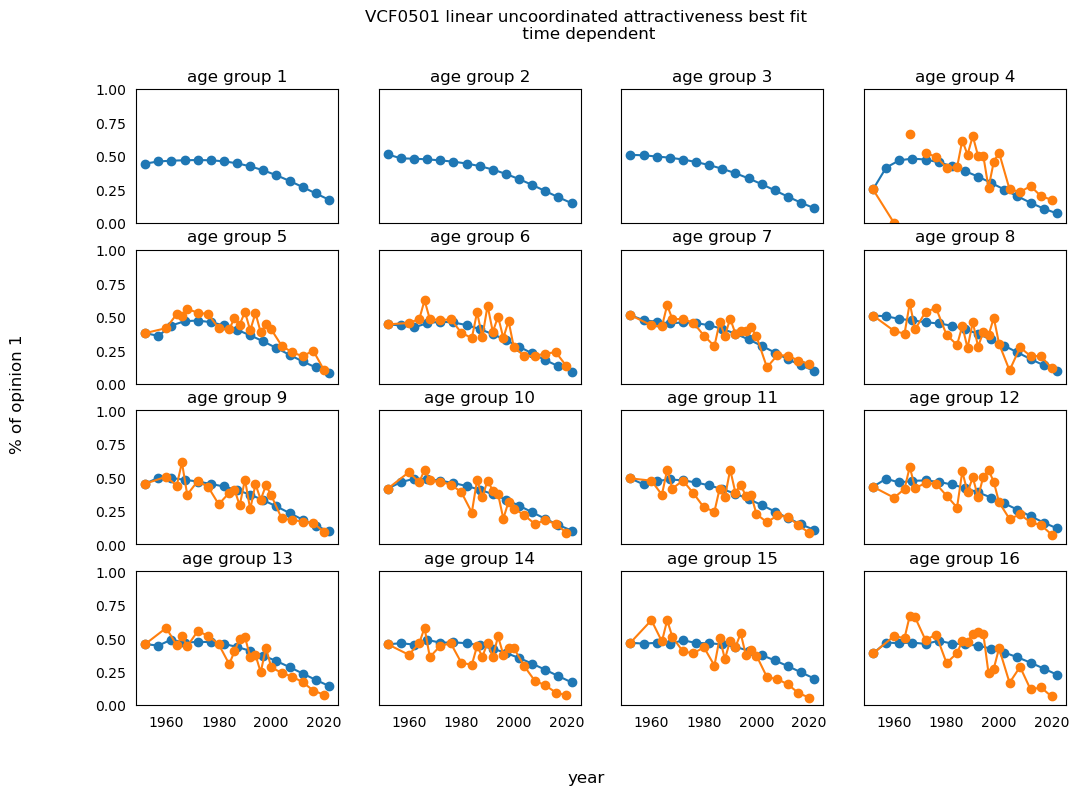

In [25]:
be = luopt[0] * np.ones(tmax-1) + luopt[1] * np.arange(0, tmax-1)
ga = luopt[2] * np.ones(tmax-1) + luopt[3] * np.arange(0, tmax-1)
# sanity check
for k in range(tmax-1):
    for i in range(1, N):
        if be[k]*sum(W[i,:]) > 1 or ga[k]*sum(W[i, :])>1:
            print('Warning')
p = sim(be, ga)
# time series graph for every age group
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    axs[i,j].plot(taxis,p[k,:],'-o')
    if k in range(3,16):
        axs[i,j].plot(t,In[:,3,k-3],'-o')
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(varname + ' linear uncoordinated attractiveness best fit\n time dependent')
fig.supxlabel('year')
fig.supylabel('% of opinion 1')
plt.savefig('2opinionweightedtimefits/lut'+varname+'.jpg')
plt.show()

In [26]:
# square model
# be = c + a + i * g + i^2 * f
# ga = c - a - i * g - i^2 * f
i = 0
nt = 1000
paramrec = np.zeros((4,nt))
costrec = np.zeros(nt)
while i < nt:
    init = np.zeros(4)
    if i == 0:
        init[0] = lcopt[0]
        init[1] = lcopt[1]
        init[2] = lcopt[2]
        init[3] = 0
    else:
        init[0] = random.uniform(0,0.1)
        init[1] = random.uniform(-0.1,0.1)
        init[2] = random.uniform(-0.001, 0.001)
        init[3] = random.uniform(-0.0001,0.0001)
    beinit = (init[0] + init[1]) * np.ones(tmax-1) + init[2] * np.arange(0,tmax-1) + init[3] * (np.arange(0,tmax-1)**2)
    gainit = (init[0] - init[1]) * np.ones(tmax-1) - init[2] * np.arange(0,tmax-1) - init[3] * (np.arange(0,tmax-1)**2)
    safe = True
    for k in range(tmax-1):
        for j in range(1, N):
            if beinit[k]*sum(W[j,:])>1 or gainit[k]*sum(W[j,:])>1:
                safe = False
                break
    if safe and min(beinit) > 0 and max(beinit) < 1 and min(gainit) > 0 and max(gainit) < 1:
        paramrec[:, i] = init
        costrec[i] = Jsquare(init)
        params, costs = grad_descent(Jsquare,init,'square')
        sqopt = params[-1]
        be = (sqopt[0]+sqopt[1]) * np.ones(tmax-1) + sqopt[2] * np.arange(0,tmax-1) + sqopt[3]*(np.arange(0,tmax-1)**2)
        ga = (sqopt[0]-sqopt[1]) * np.ones(tmax-1) - sqopt[2] * np.arange(0,tmax-1) - sqopt[3]*(np.arange(0,tmax-1)**2)
        safe = True
        for k in range(tmax-1):
            for j in range(1, N):
                if be[k]*sum(W[j,:]) > 1 or ga[k]*sum(W[j, :])>1:
                    safe = False
        if np.isnan(params[-1]).any():
            continue
        if len(costs) >= 1 and min(costs) > 0 and safe:
            paramrec[:,i] = params[-1]
            costrec[i] = costs[-1]
            if i % 100 == 0:
                print(i, min(costrec[:i+1]))
            i += 1
        elif i == 0:
            i += 1

ssesq = min(costrec)
besti = np.argmin(costrec)
sqopt = paramrec[:,besti]
print('minimum SSE:',round(ssesq,4))
print('parameters:',np.around(sqopt,decimals = 5))

100 2.5987184614769454
200 2.5970796168982355
300 2.5970796168982355
400 2.589972095803701
500 2.589972095803701
600 2.5864507107950847
700 2.5864507107950847
800 2.5864507107950847
900 2.5864507107950847
minimum SSE: 2.5865
parameters: [ 2.829e-02 -1.370e-03  3.000e-04  7.000e-05]


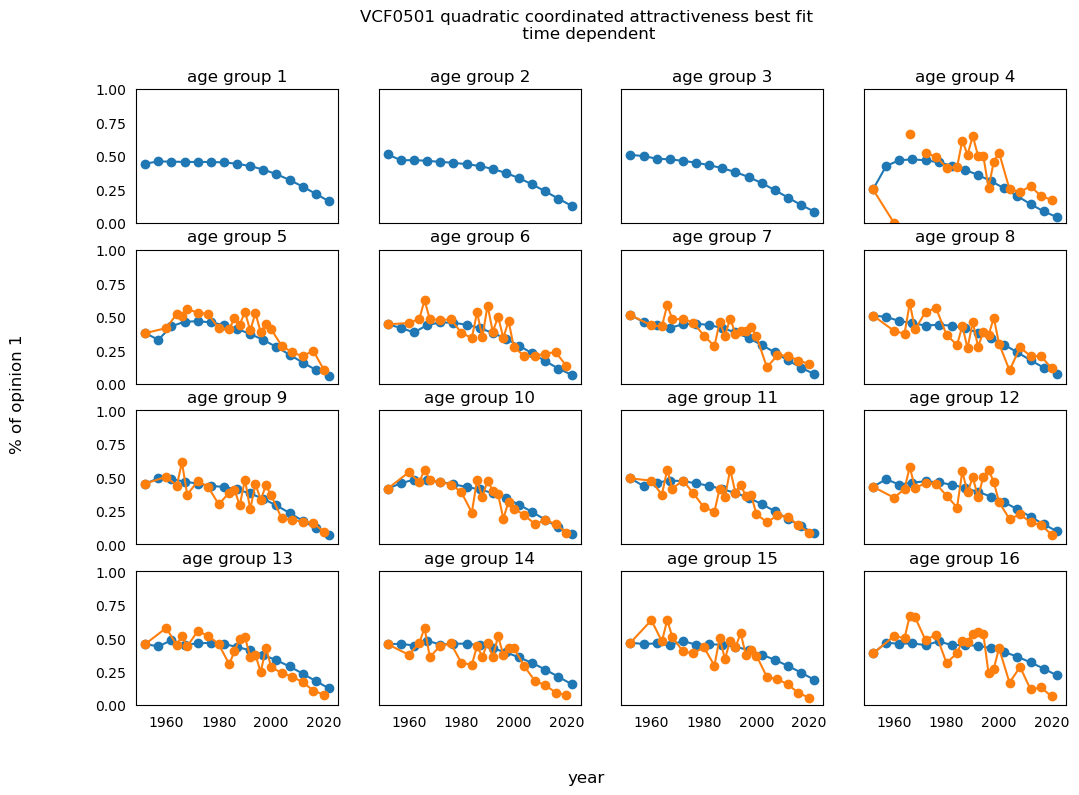

In [27]:
be = (sqopt[0]+sqopt[1]) * np.ones(tmax-1) + sqopt[2] * np.arange(0,tmax-1) + sqopt[3]*(np.arange(0,tmax-1)**2)
ga = (sqopt[0]-sqopt[1]) * np.ones(tmax-1) - sqopt[2] * np.arange(0,tmax-1) - sqopt[3]*(np.arange(0,tmax-1)**2)
p = sim(be, ga)
# sanity check
for k in range(tmax-1):
    for i in range(1, N):
        if be[k]*sum(W[i,:]) > 1 or ga[k]*sum(W[i, :])>1:
            print('Warning')
# time series graph for every age group
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    axs[i,j].plot(taxis,p[k,:],'-o')
    if k in range(3,16):
        axs[i,j].plot(t,In[:,3,k-3],'-o')
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(varname + ' quadratic coordinated attractiveness best fit\n time dependent')
fig.supxlabel('year')
fig.supylabel('% of opinion 1')
plt.savefig('2opinionweightedtimefits/quad'+varname+'.jpg')
plt.show()

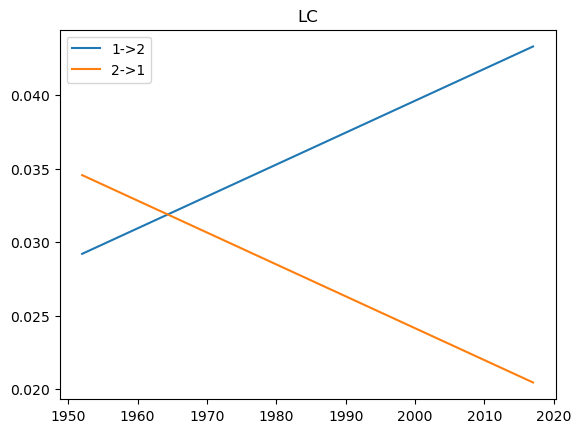

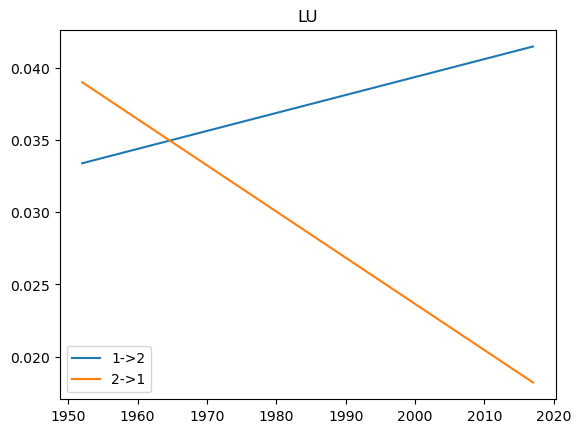

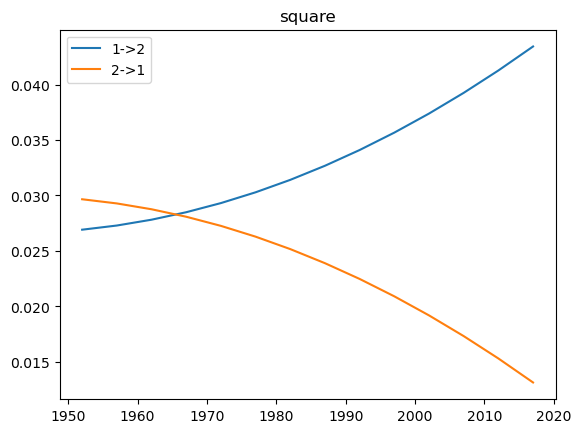

In [28]:
# plot coefficients
# lc
be = (lcopt[0] + lcopt[1]) * np.ones(tmax-1) + lcopt[2] * np.arange(0, tmax-1)
ga = (lcopt[0] - lcopt[1]) * np.ones(tmax-1) - lcopt[2] * np.arange(0, tmax-1)
plt.plot(taxis[:-1], be, label = '1->2')
plt.plot(taxis[:-1], ga, label = '2->1')
plt.legend()
plt.title('LC')
plt.show()
# lu
be = luopt[0] * np.ones(tmax-1) + luopt[1] * np.arange(0, tmax-1)
ga = luopt[2] * np.ones(tmax-1) + luopt[3] * np.arange(0, tmax-1)
plt.plot(taxis[:-1], be, label = '1->2')
plt.plot(taxis[:-1], ga, label = '2->1')
plt.legend()
plt.title('LU')
plt.show()
# square
be = (sqopt[0]+sqopt[1]) * np.ones(tmax-1) + sqopt[2] * np.arange(0,tmax-1) + sqopt[3]*(np.arange(0,tmax-1)**2)
ga = (sqopt[0]-sqopt[1]) * np.ones(tmax-1) - sqopt[2] * np.arange(0,tmax-1) - sqopt[3]*(np.arange(0,tmax-1)**2)
plt.plot(taxis[:-1], be, label = '1->2')
plt.plot(taxis[:-1], ga, label = '2->1')
plt.legend()
plt.title('square')
plt.show()

# from more complicated models to simpler models
# from square to LC
lcn = sqopt[:3]
beinit = (lcn[0]+lcn[1])*np.ones(tmax-1) + lcn[2] * np.arange(0,tmax-1)
gainit = (lcn[0]-lcn[1])*np.ones(tmax-1) - lcn[2] * np.arange(0,tmax-1)
safe = True
for k in range(tmax-1):
    for j in range(1, N):
        if beinit[k]*sum(W[j,:])>1 or gainit[k]*sum(W[j,:])>1:
            safe = False
            print('Warning')
            break
if safe and min(beinit) > 0 and max(beinit) < 1 and min(gainit) > 0 and max(gainit) < 1:
    params, costs = grad_descent(Jlct,lcn,'lct')
    lcnopt = params[-1]
    be = (lcnopt[0] + lcnopt[1]) * np.ones(tmax-1) + lcnopt[2] * np.arange(0, tmax-1)
    ga = (lcnopt[0] - lcnopt[1]) * np.ones(tmax-1) - lcnopt[2] * np.arange(0, tmax-1)
    safe = True
    for k in range(tmax-1):
        for j in range(1, N):
            if be[k]*sum(W[j,:]) > 1 or ga[k]*sum(W[j, :])>1:
                safe = False
    if np.isnan(params[-1]).any():
        safe = False
    if len(costs) >= 1 and min(costs) > 0 and safe:
        print(costs[-1])
        print(params[-1])

if safe and costs[-1] < sselc:
    sselc = costs[-1]
    lcopt = params[-1]
    be = (lcopt[0] + lcopt[1]) * np.ones(tmax-1) + lcopt[2] * np.arange(0, tmax-1)
    ga = (lcopt[0] - lcopt[1]) * np.ones(tmax-1) - lcopt[2] * np.arange(0, tmax-1)
    # sanity check
    for k in range(tmax-1):
        for i in range(1, N):
            if be[k]*sum(W[i,:]) > 1 or ga[k]*sum(W[i, :])>1:
                print('Warning')
    p = sim(be, ga)
    # time series graph for every age group
    fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
    for k in range(16):
        [i,j] = np.unravel_index(k,[4,4])
        axs[i,j].plot(taxis,p[k,:],'-o')
        if k in range(3,16):
            axs[i,j].plot(t,In[:,3,k-3],'-o')
        axs[i,j].tick_params(left = False, bottom = False)
        axs[i,j].set_title('age group '+str(k+1))
        axs[i,j].set_ylim(0,1)
        
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    fig.suptitle(varname + ' linear coordinated(time-dependent) attractiveness best fit')
    fig.supxlabel('year')
    fig.supylabel('% of opinion 1')
    plt.savefig('2opinionweightedtimefits/lct'+varname+'.jpg')
    plt.show()

# from LU to LC
c = (luopt[0] + luopt[2])/2
a = (luopt[0] - luopt[2])/2
g = (luopt[1] - luopt[3])/2
lcn = np.array([c, a, g])
beinit = (c+a)*np.ones(tmax-1) + g * np.arange(0,tmax-1)
gainit = (c-a)*np.ones(tmax-1) - g * np.arange(0,tmax-1)
safe = True
for k in range(tmax-1):
    for j in range(1, N):
        if beinit[k]*sum(W[j,:])>1 or gainit[k]*sum(W[j,:])>1:
            safe = False
            print('Warning')
            break
if safe and min(beinit) > 0 and max(beinit) < 1 and min(gainit) > 0 and max(gainit) < 1:
    params, costs = grad_descent(Jlct,lcn,'lct')
    lcnopt = params[-1]
    be = (lcnopt[0] + lcnopt[1]) * np.ones(tmax-1) + lcnopt[2] * np.arange(0, tmax-1)
    ga = (lcnopt[0] - lcnopt[1]) * np.ones(tmax-1) - lcnopt[2] * np.arange(0, tmax-1)
    safe = True
    for k in range(tmax-1):
        for j in range(1, N):
            if be[k]*sum(W[j,:]) > 1 or ga[k]*sum(W[j, :])>1:
                safe = False
                print('Warning')
    if np.isnan(params[-1]).any():
        safe = False
    if len(costs) >= 1 and min(costs) > 0 and safe:
        print(costs[-1])
        print(params[-1])

if safe and costs[-1] < sselc:
    sselc = costs[-1]
    lcopt = params[-1]
    be = (lcopt[0] + lcopt[1]) * np.ones(tmax-1) + lcopt[2] * np.arange(0, tmax-1)
    ga = (lcopt[0] - lcopt[1]) * np.ones(tmax-1) - lcopt[2] * np.arange(0, tmax-1)
    # sanity check
    for k in range(tmax-1):
        for i in range(1, N):
            if be[k]*sum(W[i,:]) > 1 or ga[k]*sum(W[i, :])>1:
                print('Warning')
    p = sim(be, ga)
    # time series graph for every age group
    fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
    for k in range(16):
        [i,j] = np.unravel_index(k,[4,4])
        axs[i,j].plot(taxis,p[k,:],'-o')
        if k in range(3,16):
            axs[i,j].plot(t,In[:,3,k-3],'-o')
        axs[i,j].tick_params(left = False, bottom = False)
        axs[i,j].set_title('age group '+str(k+1))
        axs[i,j].set_ylim(0,1)
        
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    fig.suptitle(varname + ' linear coordinated(time-dependent) attractiveness best fit')
    fig.supxlabel('year')
    fig.supylabel('% of opinion 1')
    plt.savefig('2opinionweightedtimefits/lct'+varname+'.jpg')
    plt.show()

if sselc < sselu:
    init[0] = lcopt[0] + lcopt[1]
    init[1] = lcopt[2]
    init[2] = lcopt[0] - lcopt[1]
    init[3] = -lcopt[2]
    beinit = init[0] * np.ones(tmax-1) + init[1] * np.arange(0, tmax-1)
    gainit = init[2] * np.ones(tmax-1) + init[3] * np.arange(0, tmax-1)
    safe = True
    for k in range(tmax-1):
        for i in range(1, N):
            if beinit[k]*sum(W[i,:]) > 1 or gainit[k]*sum(W[i, :])>1:
                safe = False
                break
    luopt = init
    sselu = sselc
    if safe and min(beinit) > 0 and max(beinit) < 1 and min(gainit) > 0 and max(gainit) < 1:
        params, costs = grad_descent(Jlut,init,'lut')
        lun = params[-1]
        be = lun[0] * np.ones(tmax-1) + lun[1] * np.arange(0, tmax-1)
        ga = lun[2] * np.ones(tmax-1) + lun[3] * np.arange(0, tmax-1)
        safe = True
        for k in range(tmax-1):
            for i in range(1, N):
                if be[k]*sum(W[i,:]) > 1 or ga[k]*sum(W[i, :])>1:
                    safe = False
                    print('Warning')
                    break
        if np.isnan(params[-1]).any():
            safe = False
        if len(costs) >= 1 and min(costs) > 0 and safe:
            luopt = params[-1]
            sselu = costs[-1]
            print(luopt)
            print(sselu)
            be = luopt[0] * np.ones(tmax-1) + luopt[1] * np.arange(0, tmax-1)
            ga = luopt[2] * np.ones(tmax-1) + luopt[3] * np.arange(0, tmax-1)
            # sanity check
            for k in range(tmax-1):
                for i in range(1, N):
                    if be[k]*sum(W[i,:]) > 1 or ga[k]*sum(W[i, :])>1:
                        safe = False
                        print('Warning')
                        break
            p = sim(be, ga)
            # time series graph for every age group
            fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
            for k in range(16):
                [i,j] = np.unravel_index(k,[4,4])
                axs[i,j].plot(taxis,p[k,:],'-o')
                if k in range(3,16):
                    axs[i,j].plot(t,In[:,3,k-3],'-o')
                axs[i,j].tick_params(left = False, bottom = False)
                axs[i,j].set_title('age group '+str(k+1))
                axs[i,j].set_ylim(0,1)
                
            # Hide x labels and tick labels for top plots and y ticks for right plots.
            for ax in axs.flat:
                ax.label_outer()

            fig.suptitle(varname + ' linear uncoordinated(time-dependent) attractiveness best fit')
            fig.supxlabel('year')
            fig.supylabel('% of opinion 1')
            plt.savefig('2opinionweightedtimefits/lut'+varname+'.jpg')
            plt.show()

In [29]:
def AIC(k, N, SSE):
    return 2*k + N * math.log(SSE/N)
# number of data points
ndp = np.count_nonzero(~np.isnan(In[:,3,:]))
# AIC score for 2nd simplest model
aic1 = AIC(2, ndp, ssecs)
aic2 = AIC(3, ndp, sselc)
aic3 = AIC(4, ndp, sselu)
aic4 = AIC(4, ndp, ssesq)
print('AIC score for constant model is ', np.around(aic1, decimals=4))
print('AIC score for linear coordinated model is ', np.around(aic2, decimals=4))
print('AIC score for linear uncoordinated model is', np.around(aic3, decimals=4))
print('AIC score for square model is', np.around(aic4, decimals=4))
print('Best model is model', np.argmin([aic2, aic3, aic4])+2)

print('number of data points: ', ndp)

print('constant model: ', round(ssecs,4), '\n', np.around(csopt,decimals=5))

print('Linear, coordinated model: ', round(sselc,4), '\n', np.around(lcopt,decimals=5))

print('linear, uncoordinated model: ', round(sselu,4), '\n', np.around(luopt,decimals=5))

print('quadratic coordinated model: ', round(ssesq,4), '\n', np.around(sqopt,decimals=5))

AIC score for constant model is  -1213.7775
AIC score for linear coordinated model is  -1327.0835
AIC score for linear uncoordinated model is -1326.5194
AIC score for square model is -1326.4273
Best model is model 2
number of data points:  284
constant model:  3.9002 
 [0.02148 0.002  ]
Linear, coordinated model:  2.5987 
 [ 0.03188 -0.00267  0.00108]
linear, uncoordinated model:  2.5856 
 [ 0.0334   0.00062  0.03902 -0.0016 ]
quadratic coordinated model:  2.5865 
 [ 2.829e-02 -1.370e-03  3.000e-04  7.000e-05]
